In [6]:
import os, sys
from src.spark_session import get_spark
from src.data_prep import load_raw_data
import matplotlib.pyplot as plt
import numpy as np


PROJECT_ROOT = os.path.abspath("..")   # notebooks/ -> project root
sys.path.append(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)
print("src in path:", os.path.join(PROJECT_ROOT, "src") in sys.path)

Project root: C:\Users\17573\Documents\Data_Scienist\Kaggle_competitions\Fraud_AntiMoneyLaundering_PaySim1
src in path: False


In [7]:
#Create pyspark session and load

spark = get_spark("EDA_Notebook")
df = load_raw_data(spark)

df.printSchema()
df.show(5)

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PA

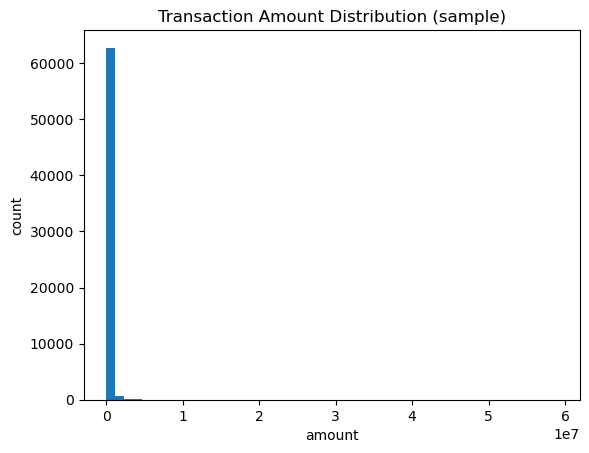

In [8]:
# Take a small random sample to plot locally
sample_df = df.select("amount", "step").sample(False, 0.01, seed=42).toPandas()
#Amount
plt.figure()
plt.hist(sample_df["amount"], bins=50)
plt.title("Transaction Amount Distribution (sample)")
plt.xlabel("amount")
plt.ylabel("count")
plt.show()

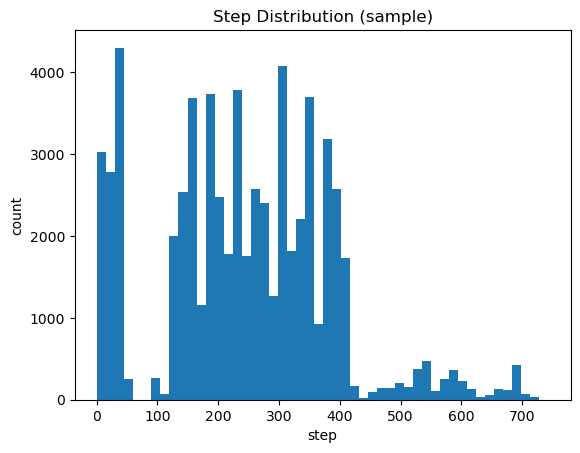

In [9]:
#Step distribution, which corresponds to 1 hour
plt.figure()
plt.hist(sample_df["step"], bins=50)
plt.title("Step Distribution (sample)")
plt.xlabel("step")
plt.ylabel("count")
plt.show()

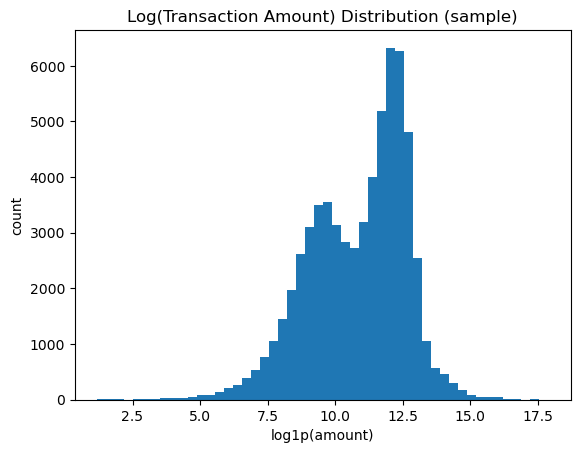

In [10]:
#Plotting log amount
plt.figure()
plt.hist(np.log1p(sample_df["amount"]), bins=50)
plt.title("Log(Transaction Amount) Distribution (sample)")
plt.xlabel("log1p(amount)")
plt.ylabel("count")
plt.show()

In [11]:
#checking class imbalance
from pyspark.sql import functions as F

df.groupBy("isFraud").count().show()

# compute fraud rate
counts = df.groupBy("isFraud").count()
counts = counts.withColumn(
    "fraction",
    F.col("count") / F.sum("count").over()
)
counts.show()


+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



TypeError: Column.over() missing 1 required positional argument: 'window'

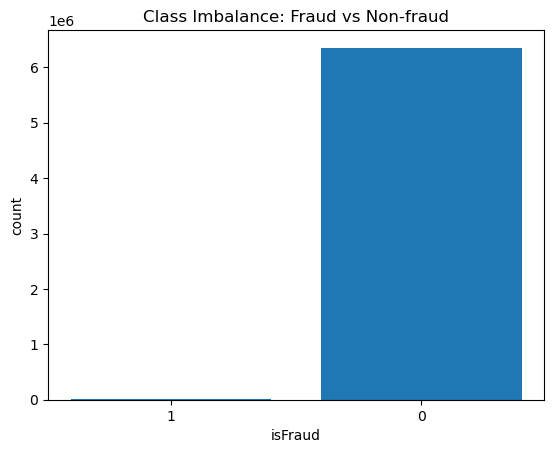

In [12]:
counts_pd = df.groupBy("isFraud").count().toPandas()

plt.figure()
plt.bar(counts_pd["isFraud"].astype(str), counts_pd["count"])
plt.title("Class Imbalance: Fraud vs Non-fraud")
plt.xlabel("isFraud")
plt.ylabel("count")
plt.show()

# Exploring suspicious patterns

In [13]:
#Let's look at fraud by transaction type
df.groupBy("type", "isFraud").count().orderBy("type", "isFraud").show(50, truncate=False)

+--------+-------+-------+
|type    |isFraud|count  |
+--------+-------+-------+
|CASH_IN |0      |1399284|
|CASH_OUT|0      |2233384|
|CASH_OUT|1      |4116   |
|DEBIT   |0      |41432  |
|PAYMENT |0      |2151495|
|TRANSFER|0      |528812 |
|TRANSFER|1      |4097   |
+--------+-------+-------+



In [14]:
#Looking at transfers that empty the account
suspicious_drain = df.filter(
    (F.col("oldbalanceOrg") > 0) &
    (F.col("newbalanceOrig") == 0) &
    (F.col("amount") > 0)
)

suspicious_drain.select(
    "step","type","amount","nameOrig",
    "oldbalanceOrg","newbalanceOrig","isFraud"
).show(20, truncate=False)

+----+--------+---------+-----------+-------------+--------------+-------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|isFraud|
+----+--------+---------+-----------+-------------+--------------+-------+
|1   |TRANSFER|181.0    |C1305486145|181.0        |0.0           |1      |
|1   |CASH_OUT|181.0    |C840083671 |181.0        |0.0           |1      |
|1   |PAYMENT |4024.36  |C1265012928|2671.0       |0.0           |0      |
|1   |DEBIT   |9644.94  |C1900366749|4465.0       |0.0           |0      |
|1   |PAYMENT |11633.76 |C1716932897|10127.0      |0.0           |0      |
|1   |CASH_OUT|229133.94|C905080434 |15325.0      |0.0           |0      |
|1   |PAYMENT |1563.82  |C761750706 |450.0        |0.0           |0      |
|1   |TRANSFER|215310.3 |C1670993182|705.0        |0.0           |0      |
|1   |TRANSFER|311685.89|C1984094095|10835.0      |0.0           |0      |
|1   |PAYMENT |6061.13  |C1043358826|443.0        |0.0           |0      |
|1   |PAYMENT |8901.99  |

In [15]:
#Many small transfers from same origin in short time windows:

small_tx = df.filter(F.col("amount") < 2000)

structuring = small_tx.groupBy("nameOrig").agg(
    F.count("*").alias("n_small_tx"),
    F.sum("amount").alias("total_small_amount"),
    F.countDistinct("nameDest").alias("unique_dests")
).orderBy(F.desc("n_small_tx"))

structuring.show(20, truncate=False)

+-----------+----------+------------------+------------+
|nameOrig   |n_small_tx|total_small_amount|unique_dests|
+-----------+----------+------------------+------------+
|C1304865807|2         |2017.17           |2           |
|C458900479 |2         |1751.25           |2           |
|C239357118 |2         |2875.54           |2           |
|C1773033163|2         |2471.69           |2           |
|C134134682 |2         |1063.05           |2           |
|C965351740 |2         |3286.58           |2           |
|C2035983399|2         |1097.73           |2           |
|C319402174 |2         |2569.79           |2           |
|C151278657 |2         |593.41            |2           |
|C1645135747|2         |2449.42           |2           |
|C1774767112|2         |2177.21           |2           |
|C501456903 |2         |1417.8400000000001|2           |
|C345144977 |2         |3065.32           |2           |
|C1087177468|2         |2476.62           |2           |
|C1900095842|2         |2255.98

In [ ]:
#Looking for structuring or smurfing
# Structuring is the deliberate act of breaking down a large financial transaction (deposit, withdrawal, or transfer) into multiple smaller amounts,
#each below the regulatory reporting threshold. It is carried out by a single individual across one or more accounts.
# Smurfing is a more complex form of structuring that involves multiple individuals, known as "smurfs," working in coordination to place illicit funds into the financial system.

In [18]:
#High fan-out accounts, refers to a suspicious transaction pattern where a single source account disperses funds to multiple destination accounts within a short period. 
fanout = df.groupBy("nameOrig").agg(
    F.countDistinct("nameDest").alias("unique_dests"),
    F.count("*").alias("n_tx"),
    F.sum("amount").alias("total_amount")
).orderBy(F.desc("unique_dests"))

fanout.show(20, truncate=False)

+-----------+------------+----+------------------+
|nameOrig   |unique_dests|n_tx|total_amount      |
+-----------+------------+----+------------------+
|C2098525306|3           |3   |378102.22         |
|C1065307291|3           |3   |113479.28         |
|C1462946854|3           |3   |166791.43         |
|C545315117 |3           |3   |2485461.6399999997|
|C400299098 |3           |3   |139408.09         |
|C1677795071|3           |3   |244735.38         |
|C1530544995|3           |3   |490535.08999999997|
|C1832548028|3           |3   |313665.82999999996|
|C363736674 |3           |3   |68726.33          |
|C2051359467|3           |3   |89313.36          |
|C1902386530|3           |3   |763712.79         |
|C1999539787|3           |3   |290555.01         |
|C724452879 |3           |3   |838815.3          |
|C1784010646|3           |3   |436700.25         |
|C1976208114|3           |3   |511130.35000000003|
|C849745739 |2           |2   |593020.19         |
|C1919727194|2           |2   |

In [ ]:
#If we want to save a cleaned sample for fast iteration
#df_sample = df.sample(False, 0.1, seed=42)
#df_sample.write.mode("overwrite").parquet("../data/processed/df_sample.parquet")

In [19]:
#Shut down spark
spark.stop()